In [1]:
import os
import json
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

import mlflow

from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier


from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt

from sklearn import metrics
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_recall_fscore_support

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

import logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

import warnings
warnings.filterwarnings("ignore")

/Users/mdurango/Proyect/Mlops-platzi/.venv/lib/python3.9/site-packages/pydantic/_internal/_fields.py:149: UserWarning: Field "model_server_url" has conflict with protected namespace "model_".

You may be able to resolve this warning by setting `model_config['protected_namespaces'] = ()`.
  warnings.warn(
/Users/mdurango/Proyect/Mlops-platzi/.venv/lib/python3.9/site-packages/pydantic/_internal/_config.py:318: UserWarning: Valid config keys have changed in V2:
* 'schema_extra' has been renamed to 'json_schema_extra'
  warnings.warn(message, UserWarning)


### Model building baseline with mlflow tracking 

In [2]:
def read_csv(file_name: str, path="data/data_processed") -> pd.DataFrame:
    """
    Read csv file
    :param file_name: file name
    :param path: path to the file
    :return: pandas dataframe
    """
    return pd.read_csv(os.path.join(path, file_name))

In [3]:
df_tickets = read_csv("tickets_inputs_eng_1.csv")

In [4]:
df_tickets.shape

(18961, 4)

In [5]:
df_tickets.sample(5)

,complaint_what_happened,ticket_classification,processed_text,relevant_topics
18714,I am a victim of identity theft and as a resul...,Debt collection + Credit card debt,victim ident theft result fraudul activ credit...,Mortgage/Loan
15487,After being discharged from Bankruptcy in XXXX...,Debt collection + I do not know,discharg bankruptci messag mail prompt call ma...,Mortgage/Loan
10093,Way to many overdraft fees. I've been a long t...,Checking or savings account + Checking account,way mani overdraft fee time custom fee becom r...,Mortgage/Loan
12127,We check our balance on XX/XX/XXXX and it had ...,Checking or savings account + Checking account,check balanc account food transact deduct bala...,Mortgage/Loan
12368,CHASE Bank sent me a letter indicating that it...,Bank account or service + Checking account,bank letter indic decid check account year con...,Mortgage/Loan


In [6]:
df_tickets.relevant_topics.value_counts() #positivo para desbalance but, la vida es así y hay que seguir adelante

relevant_topics
Mortgage/Loan                    16376
Bank Account Services             2358
Credit Report or Prepaid Card      227
Name: count, dtype: int64

In [7]:
def data_transform(df: pd.DataFrame):
    """This function transform the data into X and y
    Args:
      df (pd.DataFrame): dataframe with the data
    Returns:
      X (pd.Series): series with the text
      y (pd.Series): series with the labels"""
    X = df["processed_text"]
    y = df["relevant_topics"]

    return X, y


def read_idx2label(json_path: str) -> pd.Series:
    """This function read the json file and return a dictionary
    Args:
      json_path (str): path to the json file
     Returns:
      idx2label (dict): dictionary with the mapping"""
    with open(json_path) as f:
        idx2label = json.load(f)
    return idx2label


def decode_labels_into_idx(labels: pd.Series, idx2label: dict) -> pd.Series:
    """This function decode the labels into idx
    Args:
      labels (pd.Series): series with the labels
      idx2label (dict): dictionary with the mapping
     Returns:
      labels (pd.Series): series with the labels decoded
    """
    return labels.map(idx2label)


def fit_transform(X: pd.Series) -> np.ndarray:
    count_vectorizer = CountVectorizer()
    X_vectorized = count_vectorizer.fit_transform(X)
    return X_vectorized


def transform_tfidf(X_vectorized: object) -> np.ndarray:
    tfidf_transformer = TfidfTransformer()
    X_tfidf = tfidf_transformer.fit_transform(X_vectorized)
    return X_tfidf


def split_train_test(
    X_tfidf: np.array, y: pd.Series, test_size: float = 0.3, random_state: int = 42
) -> tuple:
    """This function split the data into train and test
    Args:
      X_tfidf (np.array): array with the vectorized data
      y (pd.Series): series with the labels
      test_size (float): test size
      random_state (int): random state
     Returns:
      X_train (np.array): array with the vectorized data for train
      X_test (np.array): array with the vectorized data for test
      y_train (pd.Series): series with the labels for train
      y_test (pd.Series): series with the labels for test
    """
    X_train, X_test, y_train, y_test = train_test_split(
        X_tfidf, y, test_size=test_size, random_state=random_state
    )
    return X_train, X_test, y_train, y_test


def display_classification_report(model: object, 
                                  name_model: str, 
                                  developer: str, 
                                  X_train: np.array, 
                                  X_test: np.array, 
                                  y_train: np.array, 
                                  y_test: np.array, 
                                  ):
    """This function display the classification report
    Args:
      model (object): model
      X_train (np.array): array with the vectorized data for train
      X_test (np.array): array with the vectorized data for test
      y_train (pd.Series): series with the labels for train
      y_test (pd.Series): series with the labels for test
     Returns:
      metric (list): list with the metrics"""

    metric = []
    y_train_pred_proba = model.predict_proba(X_train)
    y_test_pred_proba = model.predict_proba(X_test)
    roc_auc_score_train = round(
        roc_auc_score(
            y_train, y_train_pred_proba, average="weighted", multi_class="ovr"
        ),
        2,
    )
    roc_auc_score_test = round(
        roc_auc_score(y_test, y_test_pred_proba, average="weighted", multi_class="ovr"),
        2,
    )
    print("ROC AUC Score Train:", roc_auc_score_train)
    print("ROC AUC Score Test:", roc_auc_score_test)
    metric.extend([roc_auc_score_train, roc_auc_score_test])

    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    (
        precision_train,
        recall_train,
        fscore_train,
        support_train,
    ) = precision_recall_fscore_support(y_train, y_train_pred, average="weighted")
    (
        precision_test,
        recall_test,
        fscore_test,
        support_test,
    ) = precision_recall_fscore_support(y_test, y_test_pred, average="weighted")

    acc_score_train = round(accuracy_score(y_train, y_train_pred), 2)
    acc_score_test = round(accuracy_score(y_test, y_test_pred), 2)

    metric.extend(
        [
            acc_score_train,
            acc_score_test,
            round(precision_train, 2),
            round(precision_test, 2),
            round(recall_train, 2),
            round(recall_test, 2),
            round(fscore_train, 2),
            round(fscore_test, 2),
        ]
    )

    print("Train Accuracy: ", acc_score_train)
    print("Test Accuracy: ", acc_score_test)

    model_report_train = classification_report(y_train, y_train_pred)
    model_report_test = classification_report(y_test, y_test_pred)

    print("Classification Report for Train:\n", model_report_train)
    print("Classification Report for Test:\n", model_report_test)

    # Plot the confusion matrix
    fig, ax = plt.subplots(figsize=(12, 8))
    # Create the confusion matrix
    cm = confusion_matrix(y_test, y_test_pred)
    cmp = ConfusionMatrixDisplay(cm, display_labels=model.classes_)
    cmp.plot(ax=ax)

    plt.xticks(rotation=80)
    plt.show()
    return metric


In [8]:
folds = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 40)

In [9]:
def grid_search(model,folds,params,scoring):
    
    grid_search = GridSearchCV(model,
                                cv=folds, 
                                param_grid=params, 
                                scoring=scoring, 
                                n_jobs=-1, verbose=1)
    return grid_search

In [10]:
def print_best_score_params(model):
    print("Best Score: ", model.best_score_)
    print("Best Hyperparameters: ", model.best_params_)

In [11]:
idx2label = read_idx2label(json_path="data/data_processed/topic_mapping_1.json")
label2idx = {value: key for key, value in idx2label.items()}

X, y = data_transform(df_tickets)
y = decode_labels_into_idx(labels=y, idx2label=label2idx)

X_vectorized = fit_transform(X.values)
X_tfidf = transform_tfidf(X_vectorized)
X_train, X_test, y_train, y_test = split_train_test(X_tfidf, y)

In [16]:
y_test.value_counts()

relevant_topics
2    4905
0     705
1      79
Name: count, dtype: int64

ROC AUC Score Train: 0.61
ROC AUC Score Test: 0.51
Train Accuracy:  0.86
Test Accuracy:  0.86
Classification Report for Train:
               precision    recall  f1-score   support

           0       0.25      0.00      0.00      1653
           1       0.00      0.00      0.00       148
           2       0.86      1.00      0.93     11471

    accuracy                           0.86     13272
   macro avg       0.37      0.33      0.31     13272
weighted avg       0.78      0.86      0.80     13272

Classification Report for Test:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00       705
           1       0.00      0.00      0.00        79
           2       0.86      1.00      0.93      4905

    accuracy                           0.86      5689
   macro avg       0.29      0.33      0.31      5689
weighted avg       0.74      0.86      0.80      5689



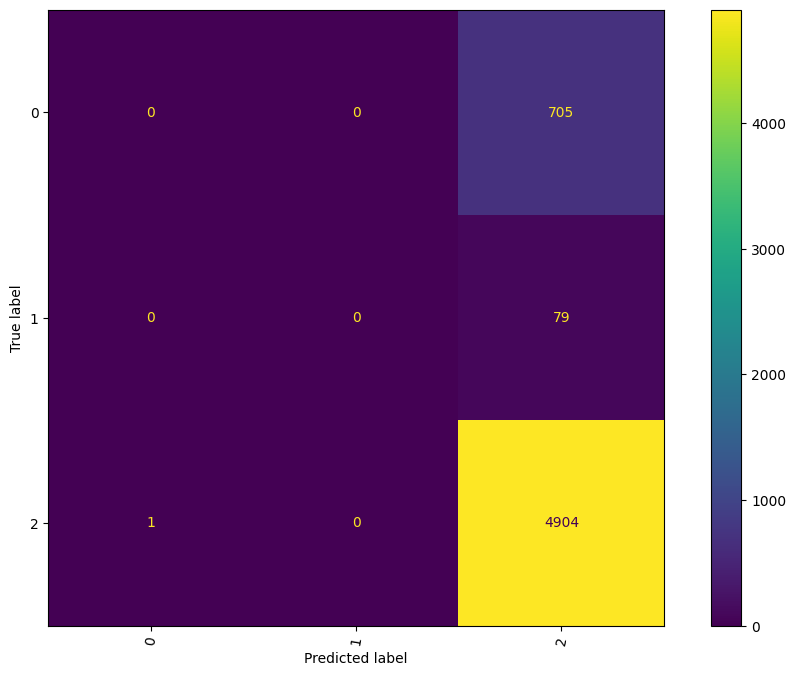

[0.61, 0.51, 0.86, 0.86, 0.78, 0.74, 0.86, 0.86, 0.8, 0.8]

In [12]:
mnb = MultinomialNB()
mnb.fit(X_train, y_train)
display_classification_report(mnb,X_train, X_test, y_train, y_test)

ROC AUC Score Train: 0.83
ROC AUC Score Test: 0.63
Train Accuracy:  0.87
Test Accuracy:  0.86
Classification Report for Train:
               precision    recall  f1-score   support

           0       0.73      0.04      0.08      1653
           1       0.00      0.00      0.00       148
           2       0.87      1.00      0.93     11471

    accuracy                           0.87     13272
   macro avg       0.53      0.35      0.33     13272
weighted avg       0.84      0.87      0.81     13272

Classification Report for Test:
               precision    recall  f1-score   support

           0       0.58      0.03      0.05       705
           1       0.00      0.00      0.00        79
           2       0.86      1.00      0.93      4905

    accuracy                           0.86      5689
   macro avg       0.48      0.34      0.33      5689
weighted avg       0.82      0.86      0.80      5689



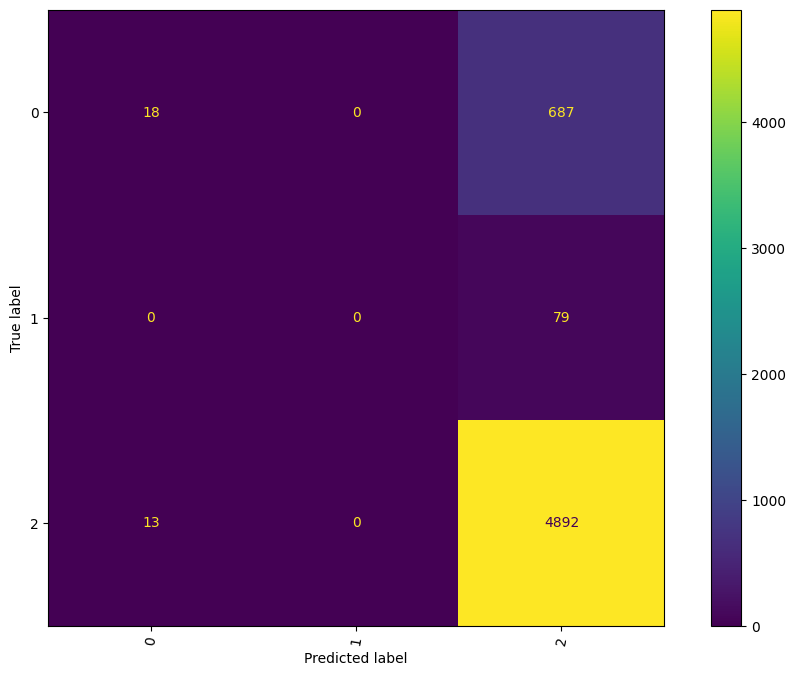

[0.83, 0.63, 0.87, 0.86, 0.84, 0.82, 0.87, 0.86, 0.81, 0.8]

In [17]:
log_reg = LogisticRegression(random_state=40,solver='liblinear')
# fit model
log_reg.fit(X_train,y_train)
# display classification report
metric2=[]
display_classification_report(log_reg,X_train, X_test, y_train, y_test)

ROC AUC Score Train: 1.0
ROC AUC Score Test: 0.54
Train Accuracy:  1.0
Test Accuracy:  0.79
Classification Report for Train:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      1653
           1       1.00      0.99      0.99       148
           2       1.00      1.00      1.00     11471

    accuracy                           1.00     13272
   macro avg       1.00      1.00      1.00     13272
weighted avg       1.00      1.00      1.00     13272

Classification Report for Test:
               precision    recall  f1-score   support

           0       0.21      0.20      0.20       705
           1       0.04      0.03      0.03        79
           2       0.87      0.88      0.88      4905

    accuracy                           0.79      5689
   macro avg       0.37      0.37      0.37      5689
weighted avg       0.78      0.79      0.78      5689



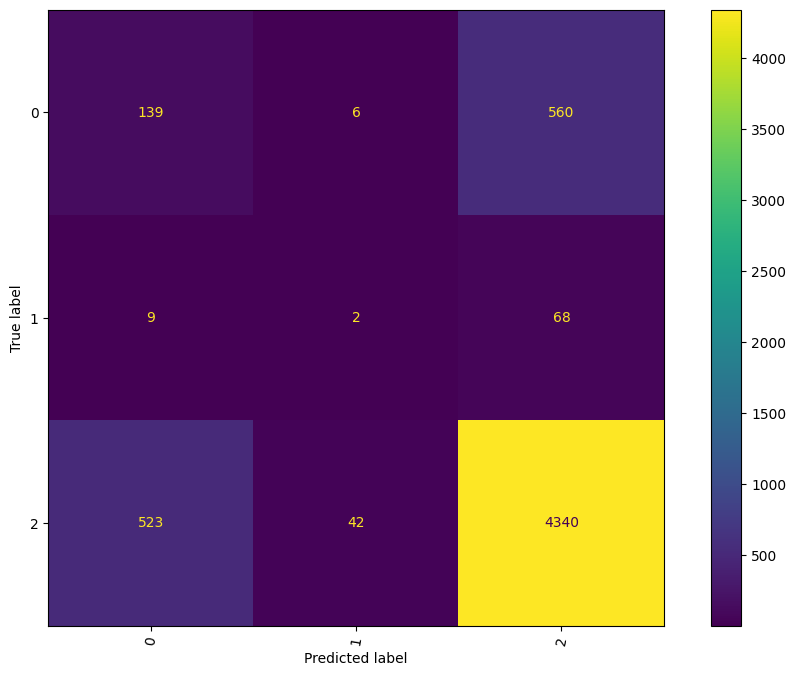

[1.0, 0.54, 1.0, 0.79, 1.0, 0.78, 1.0, 0.79, 1.0, 0.78]

In [18]:
dtc = DecisionTreeClassifier(random_state=40)
# fit model
dtc.fit(X_train,y_train)
display_classification_report(dtc,X_train, X_test, y_train, y_test)